In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.huggingface import HuggingFaceEmbedding


api_key=os.getenv("AZURE_OPENAI_KEY")
api_version="2024-02-15-preview"
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
model = "gpt-35-turbo"
deployment_name = "gpt-35-turbo"

LOCAL_EMBED_MODEL = "BAAI/bge-small-en-v1.5"

class Embedder(HuggingFaceEmbedding):
    def __init__(self, model_name: str = LOCAL_EMBED_MODEL, device: str = "cuda"):
        super().__init__(model_name, device)

class LLM(AzureOpenAI):
    def __init__(self):
        super().__init__(
            model=deployment_name,
            deployment_name=deployment_name,
            api_key=api_key,
            azure_endpoint=azure_endpoint,
            api_version=api_version,
            temperature=0.0
        )
llm = LLM()
embedder = Embedder()

In [4]:
from lavague.action_engine import ActionEngine

action_engine = ActionEngine(llm, embedder)

In [5]:
from lavague.defaults import evaluation_get_selenium_driver

get_driver = evaluation_get_selenium_driver
lavague_driver = get_driver()
_, driver = lavague_driver.getDriver()

In [6]:
import pandas as pd 
from datasets import load_dataset

dataset = load_dataset("BigAction/the-wave-clean")

df = dataset["test"].to_pandas()
df.head(5)

,query,url,html,selenium_ground_truth,ground_truth_outer_html,ground_truth_highlighted_screenshot
0,click on create account,https://en.wikipedia.org/wiki/Main_Page,"<html class=""client-js vector-feature-language...",create_account_link = driver.find_element(By.X...,"<li id=""pt-createaccount-2"" class=""user-links-...",iVBORw0KGgoAAAANSUhEUgAABkAAAAOECAYAAAD5Tf2iAA...
1,click on past,https://news.ycombinator.com/,"<html lang=""en"" op=""news""><head><meta name=""re...",link_to_click = driver.find_element(By.LINK_TE...,"<a href=""front"">past</a>",iVBORw0KGgoAAAANSUhEUgAABkAAAAOECAYAAAD5Tf2iAA...
2,click on pricing,https://www.perfagents.com/,"<html lang=""en""><head>\n <meta charset=""utf...","pricing_link = driver.find_element(By.XPATH, ""...","<a class=""font-medium px-3 lg:px-5 py-2 items-...",iVBORw0KGgoAAAANSUhEUgAABkAAAAOECAYAAAD5Tf2iAA...
3,click on SPF Justice,https://justice.belgium.be/fr,"<html lang=""fr"" dir=""ltr"" prefix=""content: htt...",spf_justice_link = driver.find_element(By.XPAT...,<span>SPF Justice</span>,iVBORw0KGgoAAAANSUhEUgAABkAAAAOECAYAAAD5Tf2iAA...
4,click on Search,https://www.cancer.gov/publications/dictionari...,"<html lang=""en"" dir=""ltr"" prefix=""og: https://...","search_button = driver.find_element(By.XPATH, ...","<input type=""submit"" class=""submit button post...",iVBORw0KGgoAAAANSUhEUgAABkAAAAOECAYAAAD5Tf2iAA...


# Evaluation of retriever only

In [10]:
from lavague.evaluator import SeleniumActionEvaluator

evaluator = SeleniumActionEvaluator(driver, action_engine)

sub_df = df.head(5)
queries = sub_df["query"].tolist()
htmls = sub_df["html"].tolist()
ground_truths = sub_df["selenium_ground_truth"].tolist()

retriever_results = evaluator.batch_evaluate_retriever(queries, htmls, ground_truths, return_context=True)
retriever_results

0it [00:00, ?it/s]/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
1it [00:01,  1.31s/it]/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
2it [00:01,  1.23it/s]/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
3it [00:03,  1.45s/it]/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Langu

,recall_retriever,precision_retriever,retrieved_context,ground_truth_outer_html,retriever_time
0,1.0,0.083333,"<div backend_node_id=""139"" class=""vector-menu ...","<li backend_node_id=""142"" class=""user-links-co...",1.202136
1,1.0,0.030303,"<tbody backend_node_id=""12""><tr backend_node_i...","<a backend_node_id=""26"" href=""front"">past</a>",0.396611
2,1.0,0.050000,"<div backend_node_id=""78"" class=""termly-styles...","<a backend_node_id=""103"" class=""font-medium px...",2.135186
3,1.0,0.041667,"_id=""205"">Depuis le 01/01/2024, la Belgique as...","<span backend_node_id=""170"">SPF Justice</span>",1.048980
4,0.0,0.000000,"<form action=""/search/results"" backend_node_id...","<input backend_node_id=""184"" class=""submit but...",0.491387


# Evaluation of LLM only

In [11]:
ground_truth_outer_htmls = retriever_results["ground_truth_outer_html"].tolist()
retrieved_contexts = retriever_results["retrieved_context"].tolist()

llm_results = evaluator.batch_evaluate_llm(queries, htmls, ground_truth_outer_htmls, retrieved_contexts)
llm_results

0it [00:00, ?it/s]

5it [00:05,  1.11s/it]


,recall_llm,precision_llm,llm_time
0,0.0,0.0,1.421249
1,1.0,1.0,0.874844
2,1.0,1.0,0.774487
3,0.0,0.0,0.821771
4,1.0,1.0,0.694846


In [12]:
results = pd.concat([retriever_results, llm_results], axis=1)
results

,recall_retriever,precision_retriever,retrieved_context,ground_truth_outer_html,retriever_time,recall_llm,precision_llm,llm_time
0,1.0,0.083333,"<div backend_node_id=""139"" class=""vector-menu ...","<li backend_node_id=""142"" class=""user-links-co...",1.202136,0.0,0.0,1.421249
1,1.0,0.030303,"<tbody backend_node_id=""12""><tr backend_node_i...","<a backend_node_id=""26"" href=""front"">past</a>",0.396611,1.0,1.0,0.874844
2,1.0,0.050000,"<div backend_node_id=""78"" class=""termly-styles...","<a backend_node_id=""103"" class=""font-medium px...",2.135186,1.0,1.0,0.774487
3,1.0,0.041667,"_id=""205"">Depuis le 01/01/2024, la Belgique as...","<span backend_node_id=""170"">SPF Justice</span>",1.048980,0.0,0.0,0.821771
4,0.0,0.000000,"<form action=""/search/results"" backend_node_id...","<input backend_node_id=""184"" class=""submit but...",0.491387,1.0,1.0,0.694846


# Evaluation of full pipeline

In [13]:
results = evaluator.batch_evaluate(queries, htmls, ground_truths, return_context=False)
results

0it [00:00, ?it/s]/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


1it [00:01,  1.32s/it]/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
2it [00:01,  1.23it/s]/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
3it [00:04,  1.46s/it]/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
4it [00:05,  1.41s/it]/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use L

,recall_retriever,precision_retriever,retriever_time,recall_llm,precision_llm,llm_time
0,1.0,0.083333,1.213714,0.0,0.0,0.891550
1,1.0,0.030303,0.390518,1.0,1.0,0.922016
2,1.0,0.050000,2.161623,1.0,1.0,1.076999
3,1.0,0.041667,1.043746,0.0,0.0,0.903095
4,0.0,0.000000,0.489357,1.0,1.0,0.838961


In [10]:
(results.recall_retriever == 1.0).mean()

0.8

<Axes: >

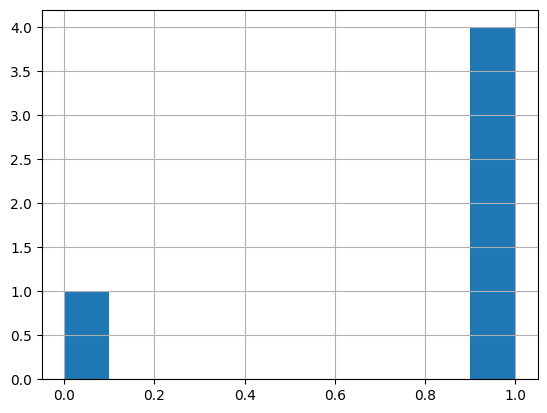

In [11]:
results.recall_retriever.hist()

In [12]:
(results.recall_llm == 1.0).mean()

0.6

LLM recall when retriever is right: 0.5


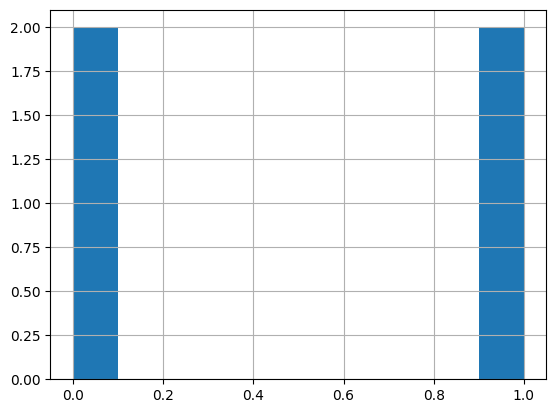

In [13]:
right_retriever = results.loc[results.recall_retriever == 1.0]
right_retriever.recall_llm.hist()
print(f"LLM recall when retriever is right: {(right_retriever.recall_llm == 1.0).mean()}")